## Example3.2: 1000 Cell Microcircuit Simulation


 Plotting cell bodies ...

 Plotting spiking activity ...


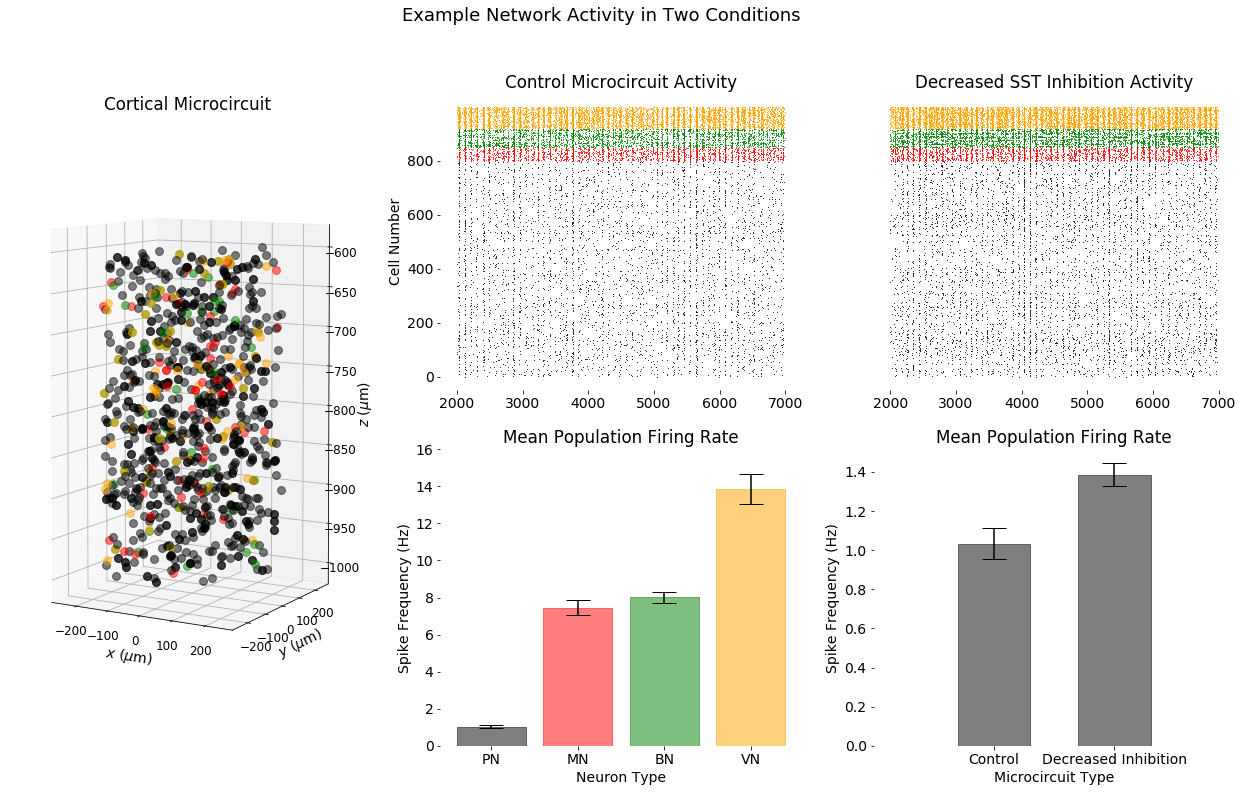

In [2]:
#================================================================================================================
# 2020 Hay lab, Krembil Centre for Neuroinformatics, Summer School. Code available for educational purposes only
#================================================================================================================
#===================================================================
# Import Modules and load relevant files
#===================================================================
import os
from os.path import join
import sys
import zipfile
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
from matplotlib.collections import PolyCollection
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import scipy
from scipy import signal as ss
from scipy import stats as st
from mpi4py import MPI
import math
import neuron
from neuron import h, gui
import LFPy
from LFPy import NetworkCell, Network, Synapse, RecExtElectrode, StimIntElectrode
from net_params import *
import h5py

#===================================================================
# Simulation Details
#===================================================================

'''
1000 total cells:
    800 Pyramidal Neurons
    50 SST/Martinotti Interneurons
    70 Basket Interneurons
    80 VIP Interneurons
    
Simulation time: 7000 ms (2000ms transient, 5000ms simulation)

LFP: 2 electrodes: -400um, -1000um 
ECoG: 1 electrode at pial surface: 0um
EEG: 1 electrode at scalp surface: 10000um

Run 1: Healthy Circuit
Run 2: Depression Circuit, Decreased SST Inhibition (50% reduction)

Cortical Microcircuit Activity:
    SPIKES: Neuron spike times
    OUTPUT: LFP timeseries for each electrode
    DIPOLEMOMENT: x,y,z-components of current-dipole moment for EEG and ECoG
'''

#===================================================================
# Plotting
#===================================================================
font={'size':14}
matplotlib.rc('font', **font)
SPIKES_1 = np.load('Circuit_output/E3_2/SPIKES_1.npy', allow_pickle=True)
SPIKES_2 = np.load('Circuit_output/E3_2/SPIKES_2.npy', allow_pickle=True)


#===================================
# Population Cell Bodies
#===================================
print('\n','Plotting cell bodies ...')
popnames = ['HL23PN1', 'HL23MN1', 'HL23BN1', 'HL23VN1']
clrs = {'HL23PN1':'k',
        'HL23MN1':'red',
        'HL23BN1':'green',
        'HL23VN1':'orange'}
filename = "Circuit_output/e3_2/3_2_cell_positions_and_rotations.h5"
tvec = np.arange(7000 / 0.0625 + 1) * 0.0625
fig = plt.figure(figsize=([22, 12]))
ax = fig.add_subplot(131, projection='3d')
ax.view_init(elev=5)
for name in popnames:
    with h5py.File(filename, "r") as f:
        for i in range(len(f[name])):
            ax.scatter(f[name][i][1], f[name][i][2], f[name][i][3],c=clrs[name], marker='.', s=250, alpha=.5)
    ax.set_xlabel('$x$ ($\mu$m)')
    ax.set_ylabel('$y$ ($\mu$m)')
    ax.set_zlabel('$z$ ($\mu$m)')
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='z', labelsize=12)
    ax.zaxis.labelpad=15
    ax.set_title('Cortical Microcircuit', y=1.05)


#===================================
#Raster Plots
#===================================
print('\n','Plotting spiking activity ...')
SPIKES = [SPIKES_1[0], SPIKES_2[0]]
subplot = [232,233]
title = ['Control Microcircuit Activity', 'Decreased SST Inhibition Activity']
ylabel = ['Cell Number', '']
yticks = [np.arange(0, 1000, 200), []]

for i, run in enumerate(SPIKES):
    ax = fig.add_subplot(subplot[i], frameon=False)
    for color, name, spts, gids in zip(clrs, popnames, run.item(0)['times'], run.item(0)['gids']):
        t = []
        g = []
        for spt, gid in zip(spts, gids):
            t = np.r_[t, spt]
            g = np.r_[g, np.zeros(spt.size)+gid]
        ax.plot(t[t >= 2000], g[t >= 2000], '|', color=clrs[name], markersize=.8)
    ax.set_ylabel(ylabel[i])
    ax.set_yticks(yticks[i])
    ax.set_title(title[i])


#===================================
# Spike Rates
#===================================
all_means_1 = []
all_means_2 = []

for s in SPIKES_1:
    PN = []
    for j in range(len(s.item(0)['times'][0])): 
        Hz = np.array([(s.item(0)['times'][0][j].size)/7])
        PN.append(Hz)
    MN = []
    for j in range(len(s.item(0)['times'][1])):
        Hz = np.array([(s.item(0)['times'][1][j].size)/7])
        MN.append(Hz)
    BN = []
    for j in range(len(s.item(0)['times'][2])):
        Hz = np.array([(s.item(0)['times'][2][j].size)/7])
        BN.append(Hz)
    VN = []
    for j in range(len(s.item(0)['times'][3])):
        Hz = np.array([(s.item(0)['times'][3][j].size)/7])
        VN.append(Hz)
    means = [[], [], [], []]
    means[0] = np.mean(PN)
    means[1] = np.mean(MN)
    means[2] = np.mean(BN)
    means[3] = np.mean(VN)
    all_means_1.append(means)
    

for s in SPIKES_2: #for each run
    PN = []
    for j in range(len(s.item(0)['times'][0])): #PN
        Hz = np.array([(s.item(0)['times'][0][j].size)/7])
        PN.append(Hz)
    MN = []
    for j in range(len(s.item(0)['times'][1])): #PN
        Hz = np.array([(s.item(0)['times'][1][j].size)/7])
        MN.append(Hz)
    BN = []
    for j in range(len(s.item(0)['times'][2])): #PN
        Hz = np.array([(s.item(0)['times'][2][j].size)/7])
        BN.append(Hz)
    VN = []
    for j in range(len(s.item(0)['times'][3])): #PN
        Hz = np.array([(s.item(0)['times'][3][j].size)/7])
        VN.append(Hz)
    means = [[], [], [], []]
    means[0] = np.mean(PN)
    means[1] = np.mean(MN)
    means[2] = np.mean(BN)
    means[3] = np.mean(VN)
    all_means_2.append(means)


w = 0.8
x = [0, 1, 2, 3]

names = ['PN', 'MN', 'BN', 'VN']
colors = ['black', 'red', 'green','orange']

ax1 = fig.add_subplot(235, frameon=False)

ax1.bar(x = [0, 1, 2, 3],
       height=[m for m in (np.mean(all_means_1, axis=0))],
       yerr=[std for std in (np.std(all_means_1, axis=0))],
       capsize=12,
       width=w,
       tick_label=names,
       color=[clr for clr in colors],
       edgecolor=[clr for clr in colors],
       ecolor='black',
       alpha=0.5)


ax1.set_ylabel('Spike Frequency (Hz)')
ax1.set_yticks(np.arange(0, 18, 2))
ax1.set_xlabel('Neuron Type')
ax1.set_title('Mean Population Firing Rate')
ax1.grid(False)


names = ['Control', 'Decreased Inhibition']
colors = ['black', 'black']

PNm = [np.mean(all_means_1, axis=0)[0], np.mean(all_means_2, axis=0)[0]]
PNstd = [np.std(all_means_1, axis=0)[0], np.std(all_means_2, axis=0)[0]]
ax2 = fig.add_subplot(236, frameon=False)
w = 1.2
ax2.bar(x = [2,4],
       height=PNm,
       yerr=PNstd,
       capsize=12,
       width=w,
       tick_label=names,
       color=[clr for clr in colors],
       edgecolor=[clr for clr in colors],
       ecolor='black',
       alpha=0.5)
ax2.set_xlim([0, 6])
ax2.set_ylabel('Spike Frequency (Hz)')
ax2.set_xlabel('Microcircuit Type')
ax2.set_title('Mean Population Firing Rate')
ax2.grid(False)
plt.suptitle('Example Network Activity in Two Conditions', y=.98, fontsize=18)

plt.show()

Loading datasets ...

Calculating potentials...

Plotting timeseries and PSD for both conditions ...


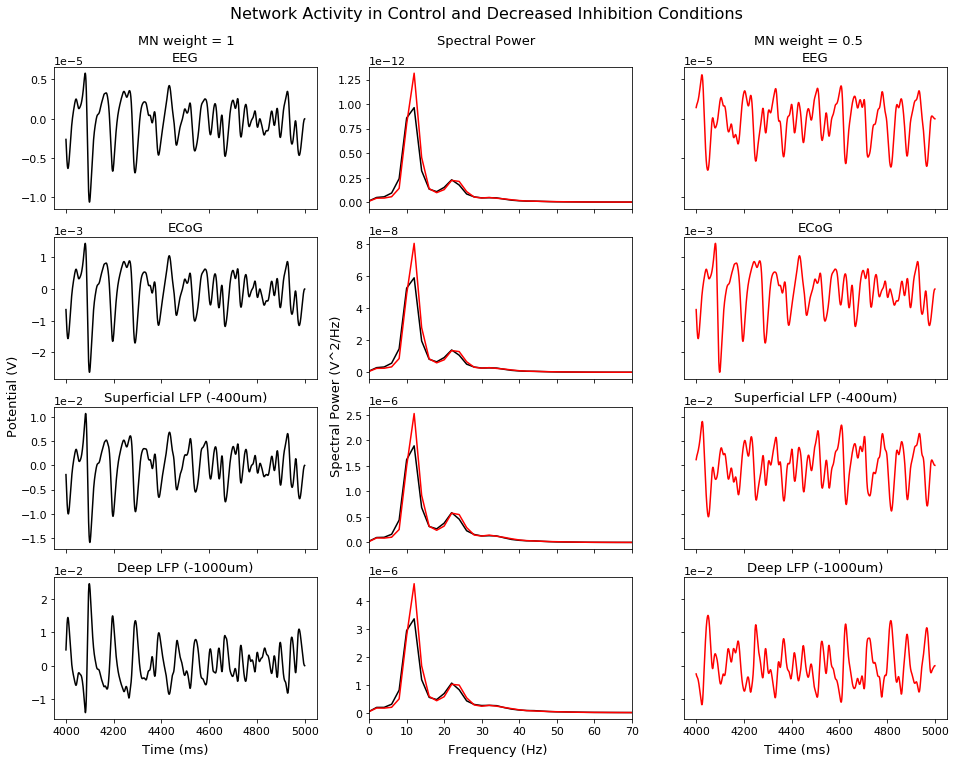

In [5]:
#===================================
# Analysis Controls
#===================================

low_cutoff = .2
high_cutoff = 50 #high frequency cutoff for lowpass filter

#===================================
# Load data from runs
#===================================
print('Loading datasets ...')
print('')
DIPOLEMOMENTS_1 = np.load('Circuit_output/E3_2/DIPOLEMOMENTS_1.npy')
DIPOLEMOMENTS_2 = np.load('Circuit_output/E3_2/DIPOLEMOMENTS_2.npy')

outputs_1_sup = np.load('Circuit_output/E3_2/outputs_1_sup.npy')
outputs_1_deep = np.load('Circuit_output/E3_2/outputs_1_deep.npy')

outputs_2_sup = np.load('Circuit_output/E3_2/outputs_2_sup.npy')
outputs_2_deep = np.load('Circuit_output/E3_2/outputs_2_deep.npy')

names = ['HL23PN1', 'HL23MN1', 'HL23BN1', 'HL23VN1']
fig = plt.figure(figsize=(16,12))
#===================================
# Analysis Parameters
#===================================
seconds_to_plot = 1 #timeseries, will plot last 'seconds_to_plot' seconds
startsclice = 2000 #2000ms transient to settle circuit
sampling_rate = 16000 #for timeseries and PSD, initial 16000
s = int(sampling_rate*((7000-startsclice)/1000) +1)#samples in series, make sure s and t1 line up, 
t1 = int(startsclice/0.0625)
nperseg = int(sampling_rate/2)

#===================================
# Filter function
#===================================
def bandPassFilter(signal):
    
    global high_cutoff, low_cutoff
    order = 2
    low = low_cutoff
    high = high_cutoff
    b, a = ss.butter(order, [low,high],btype='bandpass',fs=sampling_rate)
    y = ss.filtfilt(b, a, signal)
    return(y)  


#===================================
# Calculate EEG and ECoG potentials using 4 sphere head model
#===================================
print('Calculating potentials...')
print('')

EEGs_1 = {}
ECoGs_1 = {}

EEGs_2 = {}
ECoGs_2 = {}

radii = [79000., 80000., 85000., 90000.]
sigmas = [0.3, 1.5, 0.015, 0.3]
rz = np.array([0., 0., 78400.])
r1 = np.array([[0., 0., 79000]])
r2 = np.array([[0., 0., 90000]])

EEG_args = LFPy.FourSphereVolumeConductor(radii, sigmas, r2)
ECoG_args = LFPy.FourSphereVolumeConductor(radii, sigmas, r1)
    
DIPOLEMOMENTS = [DIPOLEMOMENTS_1, DIPOLEMOMENTS_2]
    
for i, DIPOLEMOMENT in enumerate(DIPOLEMOMENTS):
    for j, run in enumerate(DIPOLEMOMENT):
        key = str(j+1)+'_'+str(i+1)
        EEG = EEG_args.calc_potential(run, rz)
        ECoG = ECoG_args.calc_potential(run, rz)
        if i==0:
            EEGs_1[key] = EEG
            ECoGs_1[key] = ECoG
        elif i==1:
            EEGs_2[key] = EEG
            ECoGs_2[key] = ECoG

EEG_1_PSDs = []
for i,(run, value) in enumerate(EEGs_1.items()):
    value = value.flatten()
    resampled_run = ss.resample(value[t1:], s)
    filtered_run = bandPassFilter(resampled_run)
    freq, ps = ss.welch(filtered_run, fs=sampling_rate, nperseg=nperseg)
    EEG_1_PSDs.append(ps)
    if i==0:
        EEG_1 = filtered_run
        
EEG_2_PSDs = []
for i,(run, value) in enumerate(EEGs_2.items()):
    value = value.flatten()
    resampled_run = ss.resample(value[t1:], s)
    filtered_run = bandPassFilter(resampled_run)
    freq, ps = ss.welch(filtered_run, fs=sampling_rate, nperseg=nperseg)
    EEG_2_PSDs.append(ps)
    if i==0:
        EEG_2 = filtered_run

#========================================
ECoGs_1_PSDs = []
for i,(run, value) in enumerate(ECoGs_1.items()):
    value = value.flatten()
    resampled_run = ss.resample(value[t1:], s)
    filtered_run = bandPassFilter(resampled_run)
    freq, ps = ss.welch(filtered_run, fs=sampling_rate, nperseg=nperseg)
    ECoGs_1_PSDs.append(ps)
    if i==0:
        ECoG_1 = filtered_run
        

ECoGs_2_PSDs = []
for i,(run, value) in enumerate(ECoGs_2.items()):
    value = value.flatten()
    resampled_run = ss.resample(value[t1:], s)
    filtered_run = bandPassFilter(resampled_run)
    freq, ps = ss.welch(filtered_run, fs=sampling_rate, nperseg=nperseg)
    ECoGs_2_PSDs.append(ps)
    if i==0:
        ECoG_2 = filtered_run
        
#===========================================
LFP_sup_1_PSDs = []
for i, value in enumerate(outputs_1_sup):
    resampled_run = ss.resample(value[t1:], s)
    filtered_run = bandPassFilter(resampled_run)
    freq, ps = ss.welch(filtered_run, fs=sampling_rate, nperseg=nperseg)
    LFP_sup_1_PSDs.append(ps)
    if i==0:
        LFP_sup_1 = filtered_run
        
LFP_sup_2_PSDs = []
for i, value in enumerate(outputs_2_sup):
    resampled_run = ss.resample(value[t1:], s)
    filtered_run = bandPassFilter(resampled_run)
    freq, ps = ss.welch(filtered_run, fs=sampling_rate, nperseg=nperseg)
    LFP_sup_2_PSDs.append(ps)
    if i==0:
        LFP_sup_2 = filtered_run
        
#===========================================
LFP_deep_1_PSDs = []
for i, value in enumerate(outputs_1_deep):
    resampled_run = ss.resample(value[t1:], s)
    filtered_run = bandPassFilter(resampled_run)
    freq, ps = ss.welch(filtered_run, fs=sampling_rate, nperseg=nperseg)
    LFP_deep_1_PSDs.append(ps)
    if i==0:
        LFP_deep_1 = filtered_run
        
LFP_deep_2_PSDs = []
for i, value in enumerate(outputs_2_deep):
    resampled_run = ss.resample(value[t1:], s)
    filtered_run = bandPassFilter(resampled_run)
    freq, ps = ss.welch(filtered_run, fs=sampling_rate, nperseg=nperseg)
    LFP_deep_2_PSDs.append(ps)
    if i==0:
        LFP_deep_2 = filtered_run
        

EEG_1_mean_PSD = np.mean(np.array(EEG_1_PSDs), axis=0)
EEG_2_mean_PSD = np.mean(np.array(EEG_2_PSDs), axis=0)

ECoG_1_mean_PSD = np.mean(np.array(ECoGs_1_PSDs), axis=0)
ECoG_2_mean_PSD = np.mean(np.array(ECoGs_2_PSDs), axis=0)

LFP_sup_1_mean_PSD = np.mean(np.array(LFP_sup_1_PSDs), axis=0)
LFP_sup_2_mean_PSD = np.mean(np.array(LFP_sup_2_PSDs), axis=0)

LFP_deep_1_mean_PSD = np.mean(np.array(LFP_deep_1_PSDs), axis=0)
LFP_deep_2_mean_PSD = np.mean(np.array(LFP_deep_2_PSDs), axis=0)

tvec = np.arange((7000-startsclice)/(1000/sampling_rate)+1)*(1000/sampling_rate)

t2 = int(-sampling_rate*seconds_to_plot)
clr = ['k', 'red']

font={'size':11}
matplotlib.rc('font', **font)
#===================================
# Plotting
#===================================
print('Plotting timeseries and PSD for both conditions ...')
ax10 = plt.subplot2grid((4, 3), (3,0), rowspan=1, colspan=1)
ax10.plot(tvec[t2:], LFP_deep_1[t2:], c=clr[0])
ax11 = plt.subplot2grid((4, 3), (3,1), rowspan=1, colspan=1)
ax11.plot(freq,LFP_deep_1_mean_PSD, c=clr[0])
ax11.plot(freq,LFP_deep_2_mean_PSD, c=clr[1])
ax12 = plt.subplot2grid((4, 3), (3,2), rowspan=1, colspan=1, sharey=ax10)
ax12.plot(tvec[t2:], LFP_deep_2[t2:], c=clr[1])

ax1 = plt.subplot2grid((4, 3), (0,0), rowspan=1, colspan=1, sharex=ax10)
ax1.plot(tvec[t2:], EEG_1[t2:], c=clr[0])
ax2 = plt.subplot2grid((4, 3), (0,1), rowspan=1, colspan=1, sharex=ax11)
ax2.plot(freq, EEG_1_mean_PSD, c=clr[0])
ax2.plot(freq, EEG_2_mean_PSD, c=clr[1])
ax3 = plt.subplot2grid((4, 3), (0,2), rowspan=1, colspan=1, sharey=ax1, sharex=ax12)
ax3.plot(tvec[t2:], EEG_2[t2:], c=clr[1])

ax4 = plt.subplot2grid((4, 3), (1,0), rowspan=1, colspan=1, sharex=ax10)
ax4.plot(tvec[t2:], ECoG_1[t2:], c=clr[0])
ax5 = plt.subplot2grid((4, 3), (1,1), rowspan=1, colspan=1, sharex=ax11)
ax5.plot(freq, ECoG_1_mean_PSD, c=clr[0])
ax5.plot(freq, ECoG_2_mean_PSD, c=clr[1])
ax6 = plt.subplot2grid((4, 3), (1,2), rowspan=1, colspan=1, sharey=ax4, sharex=ax12)
ax6.plot(tvec[t2:], ECoG_1[t2:], c=clr[1])

ax7 = plt.subplot2grid((4, 3), (2,0), rowspan=1, colspan=1, sharex=ax10)
ax7.plot(tvec[t2:], LFP_sup_1[t2:], c=clr[0])
ax8 = plt.subplot2grid((4, 3), (2,1), rowspan=1, colspan=1, sharex=ax11)
ax8.plot(freq,LFP_sup_1_mean_PSD, c=clr[0])
ax8.plot(freq,LFP_sup_2_mean_PSD, c=clr[1])
ax9 = plt.subplot2grid((4, 3), (2,2), rowspan=1, colspan=1, sharey=ax7, sharex=ax12)
ax9.plot(tvec[t2:], LFP_sup_2[t2:], c=clr[1])

nox_timeseries = [ax1,ax3,ax4,ax6,ax7,ax9]
[plt.setp(i.get_xticklabels(), visible=False) for i in nox_timeseries]

noy_timeseries = [ax3, ax6, ax9, ax12]
[plt.setp(i.get_yticklabels(), visible=False) for i in noy_timeseries]

power_x = [ax2, ax5, ax8]
[plt.setp(i.get_xticklabels(), visible=False) for i in power_x]

for i in range(1, 13):
    exec('ax%s.ticklabel_format(axis="y", style="sci", scilimits=(0,0))'%i)
xrange = [0, high_cutoff+20]
ax11.set_xlim(xrange)

title_1 = ['EEG', 'ECoG', 'Superficial LFP (-400um)', 'Deep LFP (-1000um)']
title_1_plts = [ax1, ax4, ax7, ax10]
for title, ax in zip(title_1,title_1_plts):
    ax.set_title(title)
    
title_2_plts = [ax3, ax6, ax9, ax12]
for title, ax in zip(title_1,title_2_plts):
    ax.set_title(title)

title_fontsize = 13
plt.suptitle('Network Activity in Control and Decreased Inhibition Conditions', y=.95,fontsize=16)
fig.text(0.24, 0.91, 'MN weight = 1', ha='center', va='center', fontsize=title_fontsize)
fig.text(0.78, 0.91, 'MN weight = 0.5', ha='center', va='center', fontsize=title_fontsize)
fig.text(0.5, 0.91, 'Spectral Power', ha='center', va='center', fontsize=title_fontsize)
fig.text(0.23, 0.09, 'Time (ms)', ha='center', va='center', fontsize=title_fontsize)
fig.text(0.51, 0.09, 'Frequency (Hz)', ha='center', va='center', fontsize=title_fontsize)
fig.text(0.77, 0.09, 'Time (ms)', ha='center', va='center', fontsize=title_fontsize)
fig.text(0.09, 0.5, 'Potential (V)', ha='center', va='center', rotation='vertical', fontsize=title_fontsize)
fig.text(0.37, 0.5, 'Spectral Power (V^2/Hz)', ha='center', va='center', rotation='vertical', fontsize=title_fontsize)

plt.show()